# Neuroimaging Random Matrix Theory (RMT) Analysis

This notebook converts MATLAB code for Random Matrix Theory analysis of fMRI data to Python. The analysis identifies brain networks from ADNI data using correlation matrices and eigenvalue decomposition.

## Overview
- Load and preprocess ROI signals from fMRI data
- Compute correlation matrices for each subject
- Apply linear regression to control for covariates
- Use Random Matrix Theory to identify significant brain networks
- Calculate network strength and perform statistical comparisons
- Visualize results and save outputs

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import scipy.stats as stats
from scipy import linalg
from scipy.stats import zscore, kruskal, f_oneway
import os
import glob
import warnings
from pathlib import Path
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import nibabel as nib
from PIL import Image
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
# Set up data paths and configuration
data_partition_path = '/data/'
imaging_partition_path = '/data_imaging/'

# Data paths configuration
atlas = 'AAL3'
roi_signals_suffix = 'NiftiPreprocessedAllBatchesNorm'

# Multiple possible data paths (choose the appropriate one)
data_paths = [
    f'{data_partition_path}/UNSAM/CEMSC3/ProcesamientoADNI/DataBase/DataBaseDrive-20231031T195909Z-001/DataBase/ADNI_fMRI_screening/AAL/',
    f'{imaging_partition_path}/CovidProject/Estudio/PreprocessedMRI/DPARSF/',
    f'{imaging_partition_path}/ADNIdata/fMRI_ADNI2_ADNI3_initial_visit/'
]

# Use the first available path or specify your actual data path
data_path = data_paths[2]  # Adjust index as needed
roi_signals_path = os.path.join(data_path, f'Results{atlas}', f'ROISignals_{atlas}_{roi_signals_suffix}')
csv_filename = os.path.join(data_path, 'SubjectsDataAndTests.csv')

# Output configuration
output_path = os.path.join(data_partition_path, 'UNSAM/Brain/Alzheimer/RMT_Full_Database')
classes_to_compare = ['AD', 'CN', 'MCI']
output_path = os.path.join(output_path, atlas, roi_signals_suffix, '_'.join(classes_to_compare))

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Subjects to exclude
subjects_to_exclude = ['114_S_6039', '035_S_6953', '128_S_2002', '031_S_4021', '130_S_5231', '130_S_6647']

print(f"Data path: {data_path}")
print(f"ROI signals path: {roi_signals_path}")
print(f"Output path: {output_path}")
print(f"Classes to compare: {classes_to_compare}")

Data path: /data_imaging//ADNIdata/fMRI_ADNI2_ADNI3_initial_visit/
ROI signals path: /data_imaging//ADNIdata/fMRI_ADNI2_ADNI3_initial_visit/ResultsAAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm
Output path: /data/UNSAM/Brain/Alzheimer/RMT_Full_Database/AAL3/NiftiPreprocessedAllBatchesNorm/AD_CN_MCI
Classes to compare: ['AD', 'CN', 'MCI']


In [5]:
# Load subject information from CSV
try:
    subjects_info = pd.read_csv(csv_filename)
    print(f"Loaded subjects info with {len(subjects_info)} subjects")
    print(f"Columns: {list(subjects_info.columns)}")
    
    # Join all MCI groups together
    subjects_info.loc[subjects_info['ResearchGroup'].str.contains('MCI', na=False), 'ResearchGroup'] = 'MCI'
    
    # Display group distribution
    print(f"\nGroup distribution:")
    print(subjects_info['ResearchGroup'].value_counts())
    
except FileNotFoundError:
    print(f"CSV file not found at {csv_filename}")
    print("Please update the path or create sample data")
    # Create sample data for demonstration
    subjects_info = pd.DataFrame({
        'SubjectID': [f'Subject_{i:03d}' for i in range(100)],
        'ResearchGroup': np.random.choice(['AD', 'CN', 'MCI'], 100),
        'Age': np.random.normal(70, 10, 100),
        'Sex': np.random.choice(['M', 'F'], 100),
        'PTEDUCAT': np.random.normal(14, 3, 100),
        'CDRSB': np.random.exponential(2, 100),
        'MMSE': np.random.normal(24, 5, 100),
        'Ventricles': np.random.normal(30000, 5000, 100),
        'ImagingProtocol': ['Site1;Protocol;Scanner=Siemens'] * 100
    })
    print("Created sample data for demonstration")

Loaded subjects info with 437 subjects
Columns: ['SubjectID', 'Phase', 'Sex', 'ResearchGroup', 'Visit', 'ArchiveDate', 'StudyDate', 'Age', 'Modality', 'Description', 'ImagingProtocol', 'ImageID', 'PTEDUCAT', 'CDRSB', 'MMSE', 'DIGITSCOR', 'MOCA', 'Ventricles', 'Hippocampus', 'WholeBrain', 'MidTemp', 'ABETA', 'TAU', 'PTAU']

Group distribution:
ResearchGroup
MCI    251
AD      96
CN      90
Name: count, dtype: int64


In [7]:
# Load ROI signals from .mat files
def load_roi_signals(roi_signals_path, subjects_info, subjects_to_exclude, classes_to_compare):
    """Load and preprocess ROI signals from MATLAB files."""
    
    # Get all .mat files
    mat_files = glob.glob(os.path.join(roi_signals_path, '*.mat'))
    
    if not mat_files:
        print(f"No .mat files found in {roi_signals_path}")
        print("Creating synthetic data for demonstration...")
        return create_synthetic_data(subjects_info, classes_to_compare)
    
    subject_names = []
    roi_signals_original = []
    roi_signals = []
    cross_corr_list = []
    length_signals = []
    
    for i, mat_file in enumerate(mat_files):
        try:
            # Load MATLAB file
            mat_data = sio.loadmat(mat_file)
            signals = mat_data['signals']
            
            # Extract subject name from filename
            filename = os.path.basename(mat_file)
            name_parts = filename.replace('ROISignals_', '').replace('.mat', '')
            subject_name = name_parts
            
            # Check if subject should be included
            if subject_name not in subjects_to_exclude:
                # Find subject in CSV
                subject_idx = subjects_info[subjects_info['SubjectID'] == subject_name].index
                
                if len(subject_idx) > 0:
                    group = subjects_info.loc[subject_idx[0], 'ResearchGroup']
                    
                    # Check for NaN values
                    #if np.any(np.isnan(signals)):
                    #    print(f"Subject {subject_name} removed because of NaN ROI signals")
                    #    continue
                    
                    # Include only specified groups
                    if group in classes_to_compare:
                        subject_names.append(subject_name)
                        roi_signals_original.append(signals)
                        length_signals.append(signals.shape[0])
                        
                        # Z-score normalization (column-wise)
                        signals_norm = zscore(signals, axis=0)
                        signals_norm[np.isnan(signals_norm)] = 0  # Handle zero-variance regions
                        roi_signals.append(signals_norm)
                        
                        # Compute correlation matrix
                        corr_matrix = np.corrcoef(signals_norm.T)
                        corr_matrix[np.isnan(corr_matrix)] = 0  # Handle NaN correlations
                        cross_corr_list.append(corr_matrix)
                        
        except Exception as e:
            print(f"Error loading {mat_file}: {e}")
            continue
    
    if cross_corr_list:
        cross_corr = np.stack(cross_corr_list, axis=2)
    else:
        cross_corr = None
    
    return subject_names, roi_signals_original, roi_signals, cross_corr, length_signals

def create_synthetic_data(subjects_info, classes_to_compare):
    """Create synthetic ROI signals for demonstration."""
    print("Creating synthetic ROI signals...")
    
    # Filter subjects by group
    valid_subjects = subjects_info[subjects_info['ResearchGroup'].isin(classes_to_compare)]
    n_subjects = min(50, len(valid_subjects))  # Limit for demo
    n_rois = 116  # AAL3 atlas has 166 regions, using 116 for demo
    n_timepoints = 200
    
    subject_names = valid_subjects['SubjectID'].iloc[:n_subjects].tolist()
    roi_signals_original = []
    roi_signals = []
    cross_corr_list = []
    length_signals = []
    
    for i in range(n_subjects):
        # Generate synthetic BOLD signals
        signals = np.random.randn(n_timepoints, n_rois)
        # Add some structure (network-like correlations)
        network_signal = np.random.randn(n_timepoints, 1)
        signals[:, :20] += 0.3 * network_signal  # First network
        signals[:, 20:40] += 0.2 * np.random.randn(n_timepoints, 1)  # Second network
        
        roi_signals_original.append(signals)
        length_signals.append(n_timepoints)
        
        # Z-score normalization
        signals_norm = zscore(signals, axis=0)
        signals_norm[np.isnan(signals_norm)] = 0
        roi_signals.append(signals_norm)
        
        # Compute correlation matrix
        corr_matrix = np.corrcoef(signals_norm.T)
        corr_matrix[np.isnan(corr_matrix)] = 0
        cross_corr_list.append(corr_matrix)
    
    cross_corr = np.stack(cross_corr_list, axis=2)
    return subject_names, roi_signals_original, roi_signals, cross_corr, length_signals

# Load the data
print("Loading ROI signals...")
subject_names, roi_signals_original, roi_signals, cross_corr, length_signals = load_roi_signals(
    roi_signals_path, subjects_info, subjects_to_exclude, classes_to_compare
)

print(f"Loaded {len(subject_names)} subjects")
if cross_corr is not None:
    print(f"Correlation matrix shape: {cross_corr.shape}")
    print(f"Signal lengths range: {min(length_signals)} - {max(length_signals)} timepoints")

Loading ROI signals...
Loaded 432 subjects
Correlation matrix shape: (170, 170, 432)
Signal lengths range: 140 - 200 timepoints


In [8]:
# Extract demographics for valid subjects
def extract_demographics(subject_names, subjects_info):
    """Extract demographic and clinical information for valid subjects."""
    
    demographics = {
        'sex': [],
        'group': [],
        'age': [],
        'edu_years': [],
        'cdrsb': [],
        'mmse': [],
        'ventricles': [],
        'site': [],
        'scanner': []
    }
    
    for subject_name in subject_names:
        # Find subject in dataframe
        subject_row = subjects_info[subjects_info['SubjectID'] == subject_name]
        
        if len(subject_row) > 0:
            row = subject_row.iloc[0]
            
            demographics['sex'].append(row['Sex'])
            demographics['group'].append(row['ResearchGroup'])
            demographics['age'].append(row['Age'])
            demographics['edu_years'].append(row.get('PTEDUCAT', np.nan))
            demographics['cdrsb'].append(row.get('CDRSB', np.nan))
            demographics['mmse'].append(row.get('MMSE', np.nan))
            demographics['ventricles'].append(row.get('Ventricles', np.nan))
            
            # Extract site from subject ID (before '_S')
            site = subject_name.split('_S')[0] if '_S' in subject_name else 'Unknown'
            demographics['site'].append(site)
            
            # Extract scanner from imaging protocol
            if 'ImagingProtocol' in row and pd.notna(row['ImagingProtocol']):
                protocol_parts = str(row['ImagingProtocol']).split(';')
                if len(protocol_parts) >= 3:
                    scanner_part = protocol_parts[2].split('=')
                    scanner = scanner_part[1] if len(scanner_part) > 1 else 'Unknown'
                else:
                    scanner = 'Unknown'
            else:
                scanner = 'Unknown'
            demographics['scanner'].append(scanner)
        else:
            # Fill with NaN if subject not found
            for key in demographics.keys():
                demographics[key].append(np.nan)
    
    # Convert to numpy arrays
    for key in demographics.keys():
        demographics[key] = np.array(demographics[key])
    
    return demographics

# Extract demographics
demographics = extract_demographics(subject_names, subjects_info)

# Display demographics summary
print("Demographics Summary:")
print(f"Number of subjects: {len(demographics['group'])}")
print(f"Group distribution: {np.unique(demographics['group'], return_counts=True)}")
print(f"Sex distribution: {np.unique(demographics['sex'], return_counts=True)}")
print(f"Age: mean={np.nanmean(demographics['age']):.1f}, std={np.nanstd(demographics['age']):.1f}")
print(f"MMSE: mean={np.nanmean(demographics['mmse']):.1f}, std={np.nanstd(demographics['mmse']):.1f}")
print(f"Scanner distribution: {np.unique(demographics['scanner'], return_counts=True)}")

# Create a summary dataframe
summary_df = pd.DataFrame({
    'SubjectID': subject_names,
    'Group': demographics['group'],
    'Sex': demographics['sex'],
    'Age': demographics['age'],
    'Education': demographics['edu_years'],
    'MMSE': demographics['mmse'],
    'CDRSB': demographics['cdrsb'],
    'Site': demographics['site'],
    'Scanner': demographics['scanner']
})

print(f"\nFirst 5 subjects:")
print(summary_df.head())

Demographics Summary:
Number of subjects: 432
Group distribution: (array(['AD', 'CN', 'MCI'], dtype='<U3'), array([ 94,  89, 249]))
Sex distribution: (array(['F', 'M'], dtype='<U1'), array([206, 226]))
Age: mean=73.8, std=7.7
MMSE: mean=26.9, std=3.2
Scanner distribution: (array(['GE MEDICAL SYSTEMS', 'Philips', 'Philips Healthcare',
       'Philips Medical Systems', 'SIEMENS'], dtype='<U23'), array([ 49,   2,  21, 249, 111]))

First 5 subjects:
    SubjectID Group Sex   Age  Education  MMSE  CDRSB Site  \
0  002_S_0729   MCI   F  70.3       16.0   NaN    NaN  002   
1  002_S_1155   MCI   M  68.2       20.0  30.0    0.5  002   
2  002_S_2010   MCI   F  64.1       20.0  29.0    0.0  002   
3  002_S_2043   MCI   F  73.4       20.0  28.0    NaN  002   
4  002_S_2073   MCI   F  64.5       20.0  30.0    0.5  002   

                   Scanner  
0  Philips Medical Systems  
1                  SIEMENS  
2  Philips Medical Systems  
3  Philips Medical Systems  
4  Philips Medical Systems  


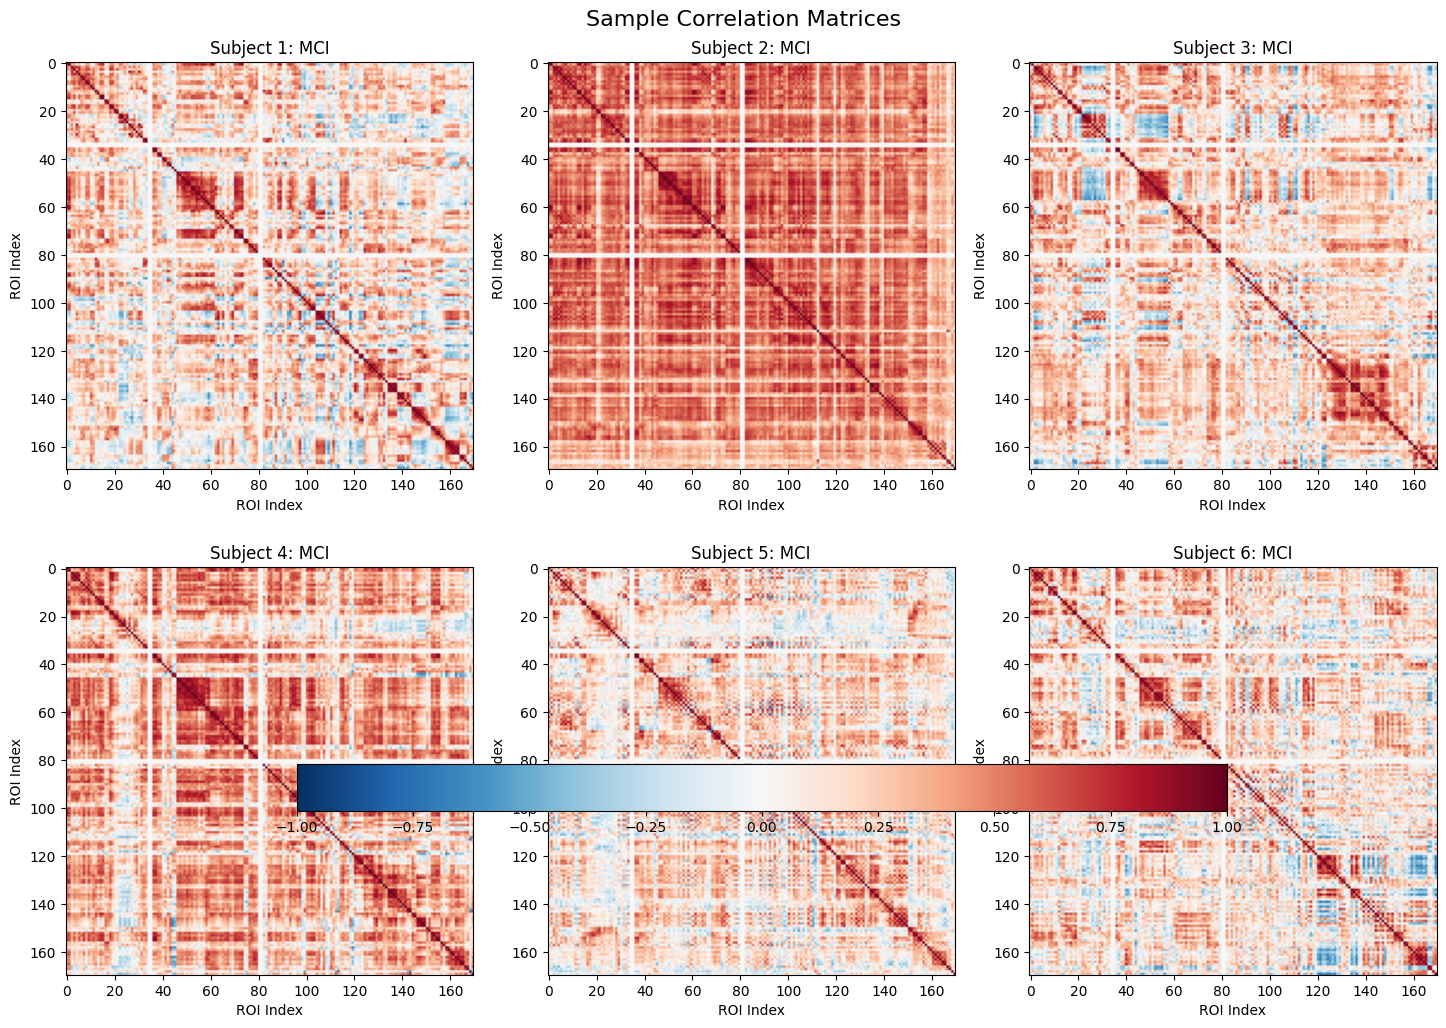

Created 20 correlation matrix frames
Note: For full GIF creation, you may need additional packages like imageio


In [9]:
# Visualize correlation matrices
def create_correlation_matrices_gif(cross_corr, subject_names, demographics, output_path):
    """Create an animated GIF showing correlation matrices for all subjects."""
    
    if cross_corr is None:
        print("No correlation matrices to visualize")
        return
    
    n_subjects = cross_corr.shape[2]
    
    # Create figure for animation
    fig, ax = plt.subplots(figsize=(10, 8))
    
    frames = []
    for i in range(min(n_subjects, 20)):  # Limit to 20 subjects for demo
        ax.clear()
        im = ax.imshow(cross_corr[:, :, i], cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title(f'Subject {i+1}: {subject_names[i]}\nGroup: {demographics["group"][i]}', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('ROI Index')
        ax.set_ylabel('ROI Index')
        
        # Add colorbar
        if i == 0:
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Correlation Coefficient')
        
        # Save frame
        frame_path = os.path.join(output_path, f'corr_matrix_frame_{i:03d}.png')
        plt.savefig(frame_path, dpi=100, bbox_inches='tight')
        frames.append(frame_path)
    
    plt.close()
    
    # Create GIF (simplified version - you may need additional packages for full GIF creation)
    print(f"Created {len(frames)} correlation matrix frames")
    print("Note: For full GIF creation, you may need additional packages like imageio")
    
    return frames

# Visualize some sample correlation matrices
if cross_corr is not None:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    n_samples = min(6, cross_corr.shape[2])
    for i in range(n_samples):
        im = axes[i].imshow(cross_corr[:, :, i], cmap='RdBu_r', vmin=-1, vmax=1)
        axes[i].set_title(f'Subject {i+1}: {demographics["group"][i]}')
        axes[i].set_xlabel('ROI Index')
        axes[i].set_ylabel('ROI Index')
    
    # Hide unused subplots
    for i in range(n_samples, 6):
        axes[i].hide()
    
    plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, shrink=0.8)
    plt.suptitle('Sample Correlation Matrices', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'sample_correlation_matrices.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create frames for animation (simplified)
    frames = create_correlation_matrices_gif(cross_corr, subject_names, demographics, output_path)
else:
    print("No correlation matrices available for visualization")

In [10]:
# Linear regression for covariate correction
def regress_out_covariates(cross_corr, demographics):
    """Apply linear regression to regress out covariates from correlation coefficients."""
    
    if cross_corr is None:
        print("No correlation matrices available")
        return None, None, None, None
    
    n_rois = cross_corr.shape[0]
    n_subjects = cross_corr.shape[2]
    
    # Prepare covariates
    age = demographics['age']
    sex_numeric = (demographics['sex'] == 'F').astype(int)  # Female = 1, Male = 0
    group_ad = (demographics['group'] == 'AD').astype(int)  # AD = 1, others = 0
    
    # Remove subjects with missing data
    valid_idx = ~(np.isnan(age) | np.isnan(sex_numeric) | np.isnan(group_ad))
    
    if np.sum(valid_idx) < 10:
        print("Not enough valid subjects for regression")
        return None, None, None, None
    
    # Filter data
    age_valid = age[valid_idx]
    sex_valid = sex_numeric[valid_idx]
    group_valid = group_ad[valid_idx]
    cross_corr_valid = cross_corr[:, :, valid_idx]
    
    # Create design matrix (with intercept)
    X = np.column_stack([np.ones(len(age_valid)), age_valid, sex_valid, group_valid])
    
    # Storage for results
    models = {}
    p_values = np.zeros((n_rois, n_rois, 4))  # Intercept, Age, Sex, Group
    coefficients = np.zeros((n_rois, n_rois, 4))
    cross_corr_residuals = np.zeros_like(cross_corr_valid)
    cross_corr_reg_out = np.zeros_like(cross_corr_valid)
    
    print("Performing linear regression for each ROI pair...")
    
    for i in range(n_rois):
        for j in range(n_rois):
            # Get correlation values for this ROI pair
            y = cross_corr_valid[i, j, :]
            
            try:
                # Fit linear model
                model = LinearRegression(fit_intercept=False)  # We already included intercept
                model.fit(X, y)
                
                # Get predictions and residuals
                y_pred = model.predict(X)
                residuals = y - y_pred
                
                # Store coefficients
                coefficients[i, j, :] = model.coef_
                
                # Calculate p-values using t-test (simplified)
                # Note: This is a simplified version - full statistical testing would require more robust methods
                mse = np.mean(residuals**2)
                var_coef = mse * np.diag(np.linalg.pinv(X.T @ X))
                t_stats = model.coef_ / np.sqrt(var_coef)
                p_values[i, j, :] = 2 * (1 - stats.t.cdf(np.abs(t_stats), len(y) - len(model.coef_)))
                
                # Store residuals (this is the corrected correlation)
                cross_corr_residuals[i, j, :] = coefficients[i, j, 0] + residuals
                
                # Manual regression out (should be same as residuals + intercept)
                y_reg_out = y - (coefficients[i, j, 1] * age_valid + 
                               coefficients[i, j, 2] * sex_valid + 
                               coefficients[i, j, 3] * group_valid)
                cross_corr_reg_out[i, j, :] = y_reg_out
                
                models[(i, j)] = {
                    'model': model,
                    'residuals': residuals,
                    'r2': r2_score(y, y_pred),
                    'mse': mse
                }
                
            except Exception as e:
                print(f"Error in regression for ROI pair ({i},{j}): {e}")
                # Fill with original values if regression fails
                cross_corr_residuals[i, j, :] = cross_corr_valid[i, j, :]
                cross_corr_reg_out[i, j, :] = cross_corr_valid[i, j, :]
    
    print("Linear regression completed")
    
    return models, p_values, coefficients, cross_corr_residuals

# Perform regression
print("Starting covariate regression...")
models, p_values, coefficients, cross_corr_residuals = regress_out_covariates(cross_corr, demographics)

if p_values is not None:
    print(f"Regression completed")
    print(f"P-values shape: {p_values.shape}")
    print(f"Coefficients shape: {coefficients.shape}")
    
    # Display some statistics
    variable_names = ['Intercept', 'Age', 'Sex', 'Group']
    for i, var_name in enumerate(variable_names):
        significant_pairs = np.sum(p_values[:, :, i] < 0.05)
        total_pairs = p_values.shape[0] * p_values.shape[1]
        print(f"{var_name}: {significant_pairs}/{total_pairs} significant ROI pairs (p < 0.05)")
else:
    print("Regression could not be performed")

Starting covariate regression...
Performing linear regression for each ROI pair...
Linear regression completed
Regression completed
P-values shape: (170, 170, 4)
Coefficients shape: (170, 170, 4)
Intercept: 21722/28900 significant ROI pairs (p < 0.05)
Age: 5290/28900 significant ROI pairs (p < 0.05)
Sex: 7622/28900 significant ROI pairs (p < 0.05)
Group: 4262/28900 significant ROI pairs (p < 0.05)


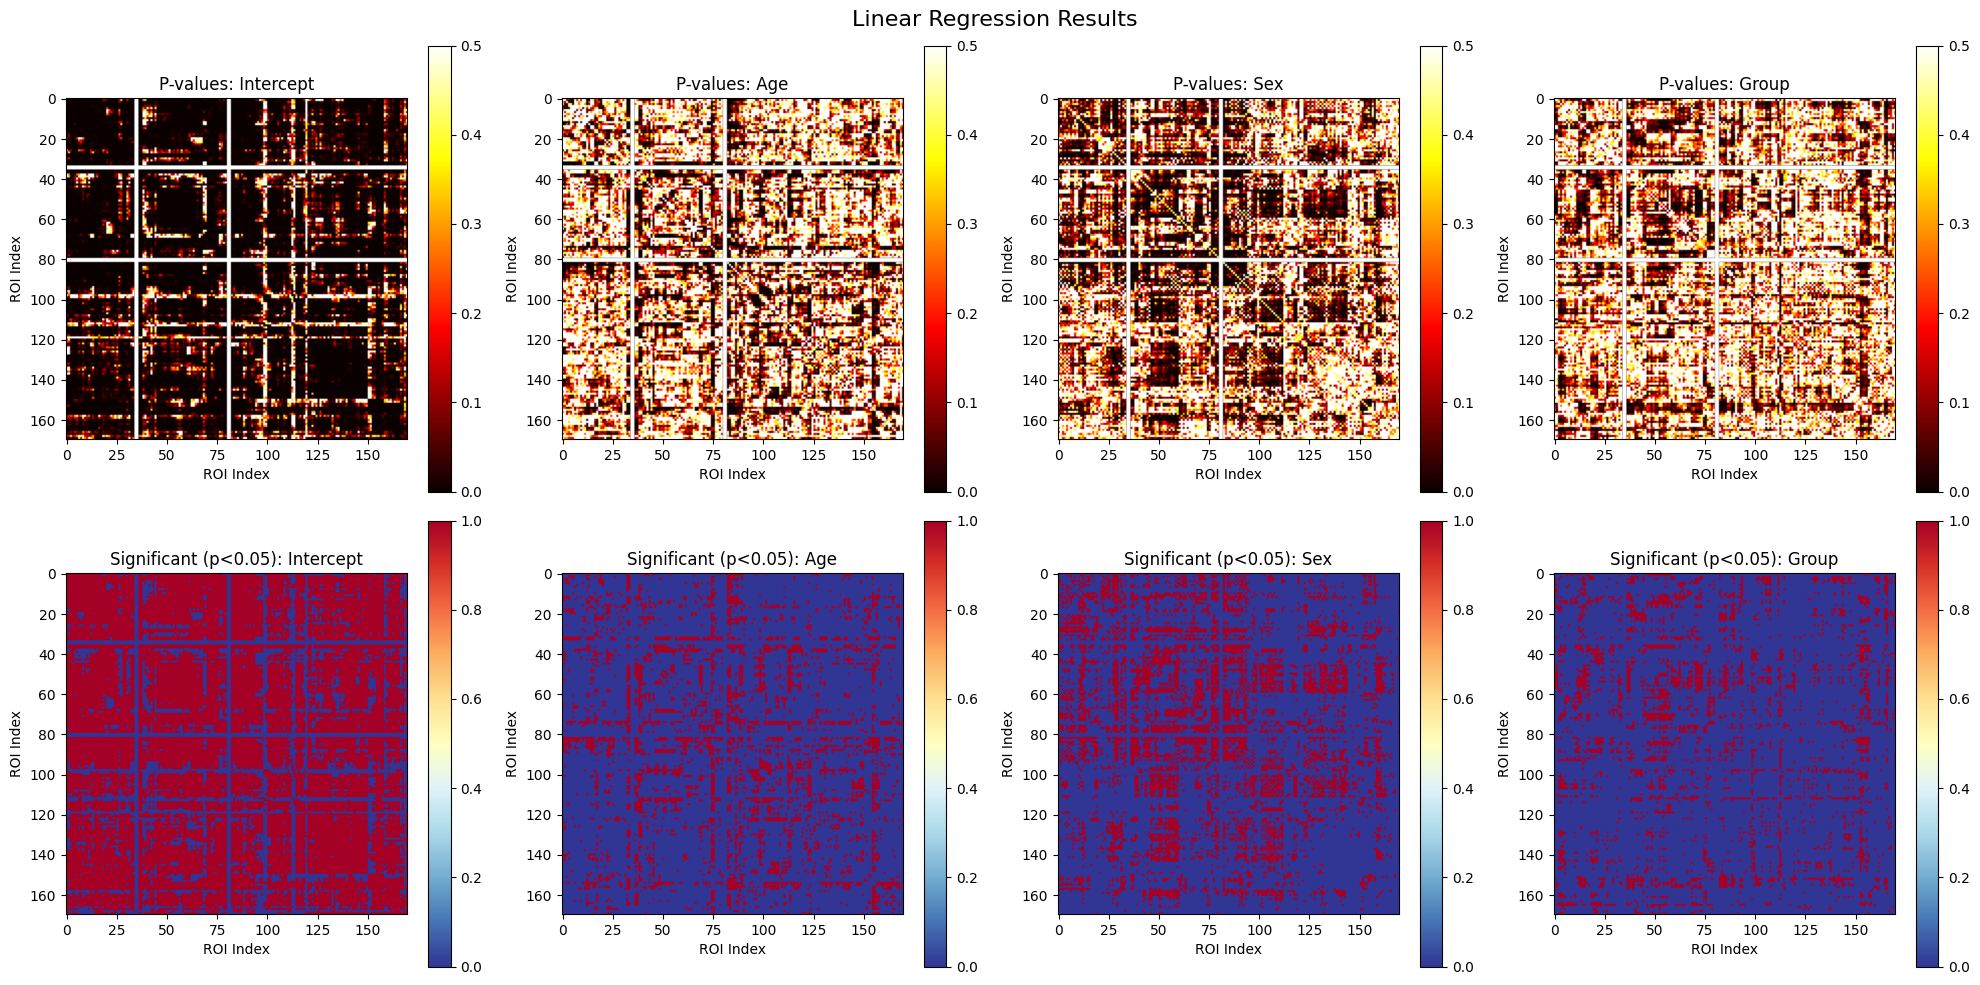

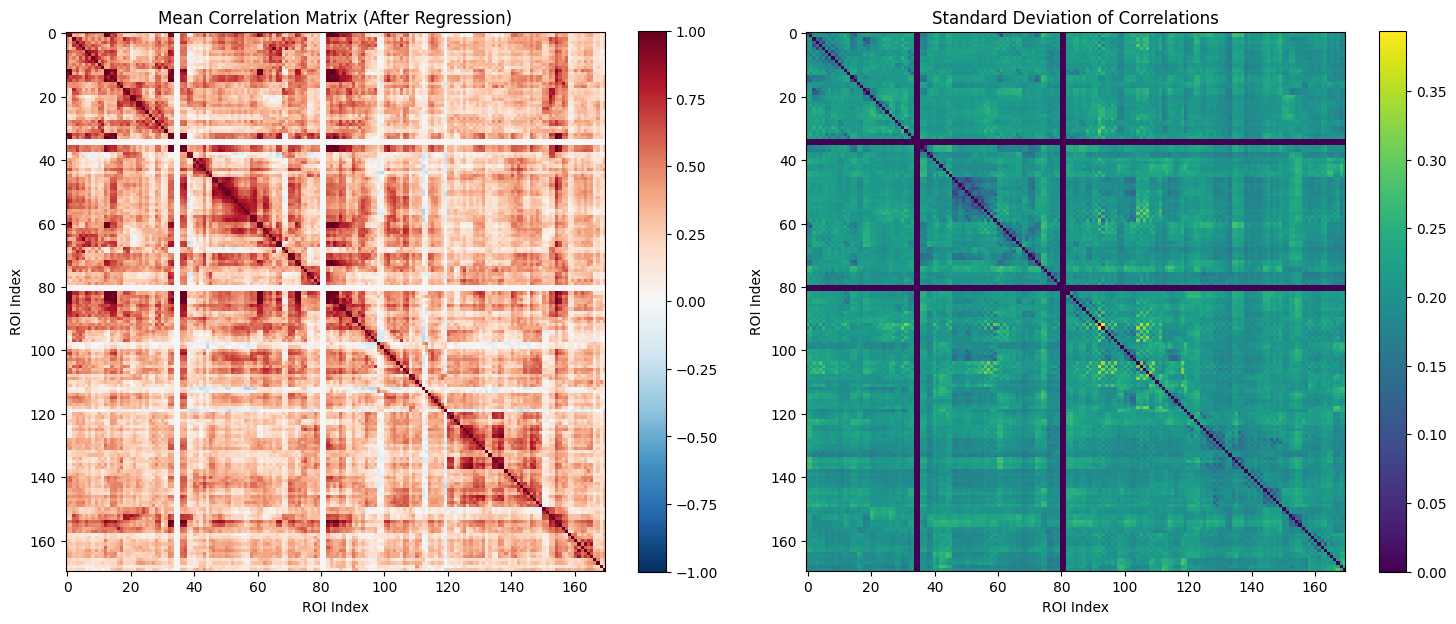

Mean correlation range: [-0.309, 1.248]
Standard deviation range: [0.000, 0.394]


In [11]:
# Visualize regression results
if p_values is not None:
    variable_names = ['Intercept', 'Age', 'Sex', 'Group']
    alpha = 0.05
    
    # Plot p-values
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # P-values
    for i, var_name in enumerate(variable_names):
        im1 = axes[0, i].imshow(p_values[:, :, i], cmap='hot', vmin=0, vmax=0.5)
        axes[0, i].set_title(f'P-values: {var_name}')
        axes[0, i].set_xlabel('ROI Index')
        axes[0, i].set_ylabel('ROI Index')
        plt.colorbar(im1, ax=axes[0, i])
        
        # Significance maps
        significance = (p_values[:, :, i] < alpha).astype(int)
        im2 = axes[1, i].imshow(significance, cmap='RdYlBu_r', vmin=0, vmax=1)
        axes[1, i].set_title(f'Significant (p<{alpha}): {var_name}')
        axes[1, i].set_xlabel('ROI Index')
        axes[1, i].set_ylabel('ROI Index')
        plt.colorbar(im2, ax=axes[1, i])
    
    plt.suptitle('Linear Regression Results', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'regression_results.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Compute mean correlation matrix after regression
    mean_cc = np.mean(cross_corr_residuals, axis=2)
    std_cc = np.std(cross_corr_residuals, axis=2)
    
    # Plot mean correlation matrix
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    im1 = axes[0].imshow(mean_cc, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[0].set_title('Mean Correlation Matrix (After Regression)')
    axes[0].set_xlabel('ROI Index')
    axes[0].set_ylabel('ROI Index')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(std_cc, cmap='viridis', vmin=0)
    axes[1].set_title('Standard Deviation of Correlations')
    axes[1].set_xlabel('ROI Index')
    axes[1].set_ylabel('ROI Index')
    plt.colorbar(im2, ax=axes[1])
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'mean_correlation_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Mean correlation range: [{np.min(mean_cc):.3f}, {np.max(mean_cc):.3f}]")
    print(f"Standard deviation range: [{np.min(std_cc):.3f}, {np.max(std_cc):.3f}]")
else:
    print("Cannot visualize regression results - no data available")

In [13]:
# Random Matrix Theory Analysis
def rmt_analysis(mean_cc, length_signals):
    """
    Perform Random Matrix Theory analysis to identify brain networks.
    
    Parameters:
    - mean_cc: Mean correlation matrix
    - length_signals: List of signal lengths for each subject
    
    Returns:
    - eigenvalues, eigenvectors, brain network indices, Marchenko-Pastur bounds
    """
    
    if mean_cc is None:
        print("No correlation matrix available for RMT analysis")
        return None, None, None, None, None
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = linalg.eigh(mean_cc)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Parameters for Marchenko-Pastur distribution
    N = mean_cc.shape[0]  # Number of ROIs
    L = min(length_signals)  # Minimum length of time series
    Q = L / N  # Ratio
    std_dev_signals = 1.0  # Signals are z-normalized
    
    # Marchenko-Pastur bounds
    lambda_min = std_dev_signals * (1 - np.sqrt(1/Q))**2
    lambda_max = std_dev_signals * (1 + np.sqrt(1/Q))**2
    
    # Find brain networks (eigenvalues outside MP distribution)
    brain_network_indices = np.abs(eigenvalues) > lambda_max
    lambda_brain_networks = eigenvalues[brain_network_indices]
    v_brain_networks = eigenvectors[:, brain_network_indices]
    
    num_brain_networks = len(lambda_brain_networks)
    
    print(f"RMT Analysis Results:")
    print(f"Number of ROIs (N): {N}")
    print(f"Minimum signal length (L): {L}")
    print(f"Ratio Q = L/N: {Q:.2f}")
    print(f"Marchenko-Pastur bounds: [{lambda_min:.3f}, {lambda_max:.3f}]")
    print(f"Number of brain networks discovered: {num_brain_networks}")
    print(f"Brain network eigenvalues: {lambda_brain_networks}")
    
    return eigenvalues, eigenvectors, brain_network_indices, (lambda_min, lambda_max), v_brain_networks

# Perform RMT analysis
if cross_corr_residuals is not None:
    mean_cc = np.mean(cross_corr_residuals, axis=2)
    eigenvalues, eigenvectors, brain_network_indices, mp_bounds, v_brain_networks = rmt_analysis(mean_cc, length_signals)
else:
    print("Using original correlation matrix for RMT analysis")
    if cross_corr is not None:
        mean_cc = np.mean(cross_corr, axis=2)
        eigenvalues, eigenvectors, brain_network_indices, mp_bounds, v_brain_networks = rmt_analysis(mean_cc, length_signals)
    else:
        eigenvalues = eigenvectors = brain_network_indices = mp_bounds = v_brain_networks = None

RMT Analysis Results:
Number of ROIs (N): 170
Minimum signal length (L): 140
Ratio Q = L/N: 0.82
Marchenko-Pastur bounds: [0.010, 4.418]
Number of brain networks discovered: 8
Brain network eigenvalues: [61.9632844  11.85327187  9.59796592  8.40353291  7.58491152  5.58491558
  5.20387474  4.55523376]


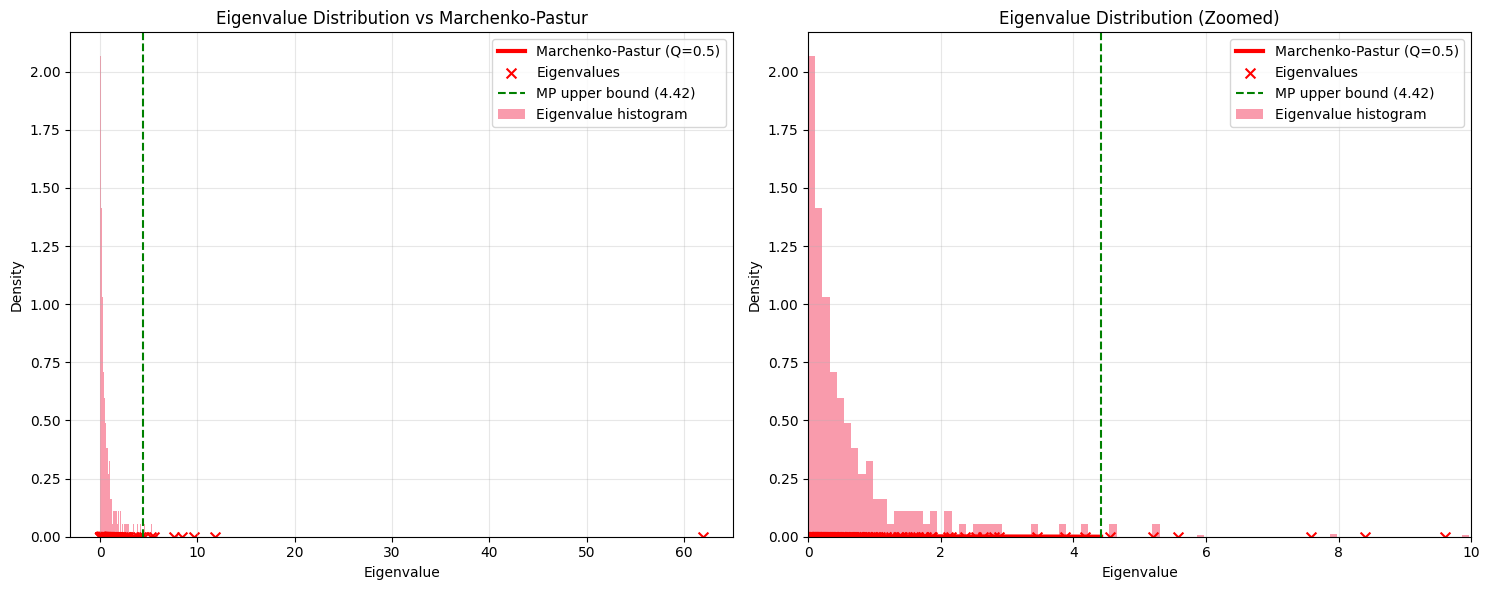


Brain networks (eigenvalues > 4.418):
  Network 1: λ = 61.963
  Network 2: λ = 11.853
  Network 3: λ = 9.598
  Network 4: λ = 8.404
  Network 5: λ = 7.585
  Network 6: λ = 5.585
  Network 7: λ = 5.204
  Network 8: λ = 4.555


In [14]:
# Visualize eigenvalue distribution and Marchenko-Pastur
def plot_eigenvalue_distribution(eigenvalues, mp_bounds, output_path):
    """Plot eigenvalue distribution compared to Marchenko-Pastur."""
    
    if eigenvalues is None:
        print("No eigenvalues to plot")
        return
    
    lambda_min, lambda_max = mp_bounds
    
    # Create histogram of eigenvalues
    num_bins = 50
    hist_bins = np.linspace(0, lambda_max * 1.2, num_bins)
    extended_bins = np.concatenate([hist_bins, np.arange(lambda_max + 1, max(np.abs(eigenvalues)) + 1)])
    
    hist_lambdas, bin_edges = np.histogram(np.abs(eigenvalues), bins=extended_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Theoretical Marchenko-Pastur distribution
    mp_bins = np.linspace(lambda_min, lambda_max, num_bins)
    N = len(eigenvalues)
    L = N * (lambda_max + lambda_min) / (2 * lambda_max)  # Approximate L from bounds
    Q = L / N
    
    # Marchenko-Pastur PDF
    def marchenko_pastur_pdf(lam, lambda_min, lambda_max, Q, sigma=1):
        if lambda_min <= lam <= lambda_max:
            return (Q / (2 * np.pi * lam * sigma**2)) * np.sqrt((lambda_max - lam) * (lam - lambda_min))
        else:
            return 0
    
    mp_pdf = np.array([marchenko_pastur_pdf(lam, lambda_min, lambda_max, Q) for lam in mp_bins])
    mp_pdf = mp_pdf / np.sum(mp_pdf) * (lambda_max - lambda_min) / num_bins  # Normalize
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Full range plot
    axes[0].bar(bin_centers, hist_lambdas, width=bin_centers[1]-bin_centers[0], 
                alpha=0.7, label='Eigenvalue histogram')
    axes[0].plot(mp_bins, mp_pdf, 'r-', linewidth=3, label=f'Marchenko-Pastur (Q={Q:.1f})')
    axes[0].scatter(np.abs(eigenvalues), np.zeros_like(eigenvalues), 
                   marker='x', s=50, color='red', label='Eigenvalues')
    axes[0].axvline(lambda_max, color='green', linestyle='--', 
                   label=f'MP upper bound ({lambda_max:.2f})')
    axes[0].set_xlabel('Eigenvalue')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Eigenvalue Distribution vs Marchenko-Pastur')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Zoomed plot (0-10 range)
    axes[1].bar(bin_centers, hist_lambdas, width=bin_centers[1]-bin_centers[0], 
                alpha=0.7, label='Eigenvalue histogram')
    axes[1].plot(mp_bins, mp_pdf, 'r-', linewidth=3, label=f'Marchenko-Pastur (Q={Q:.1f})')
    axes[1].scatter(np.abs(eigenvalues), np.zeros_like(eigenvalues), 
                   marker='x', s=50, color='red', label='Eigenvalues')
    axes[1].axvline(lambda_max, color='green', linestyle='--', 
                   label=f'MP upper bound ({lambda_max:.2f})')
    axes[1].set_xlim(0, 10)
    axes[1].set_xlabel('Eigenvalue')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Eigenvalue Distribution (Zoomed)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'eigenvalue_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Identify brain networks
    brain_networks = eigenvalues[np.abs(eigenvalues) > lambda_max]
    print(f"\nBrain networks (eigenvalues > {lambda_max:.3f}):")
    for i, eig_val in enumerate(brain_networks):
        print(f"  Network {i+1}: λ = {eig_val:.3f}")

# Plot eigenvalue distribution
if eigenvalues is not None and mp_bounds is not None:
    plot_eigenvalue_distribution(eigenvalues, mp_bounds, output_path)
else:
    print("Cannot plot eigenvalue distribution - insufficient data")

Calculating IPR for 8 brain networks...


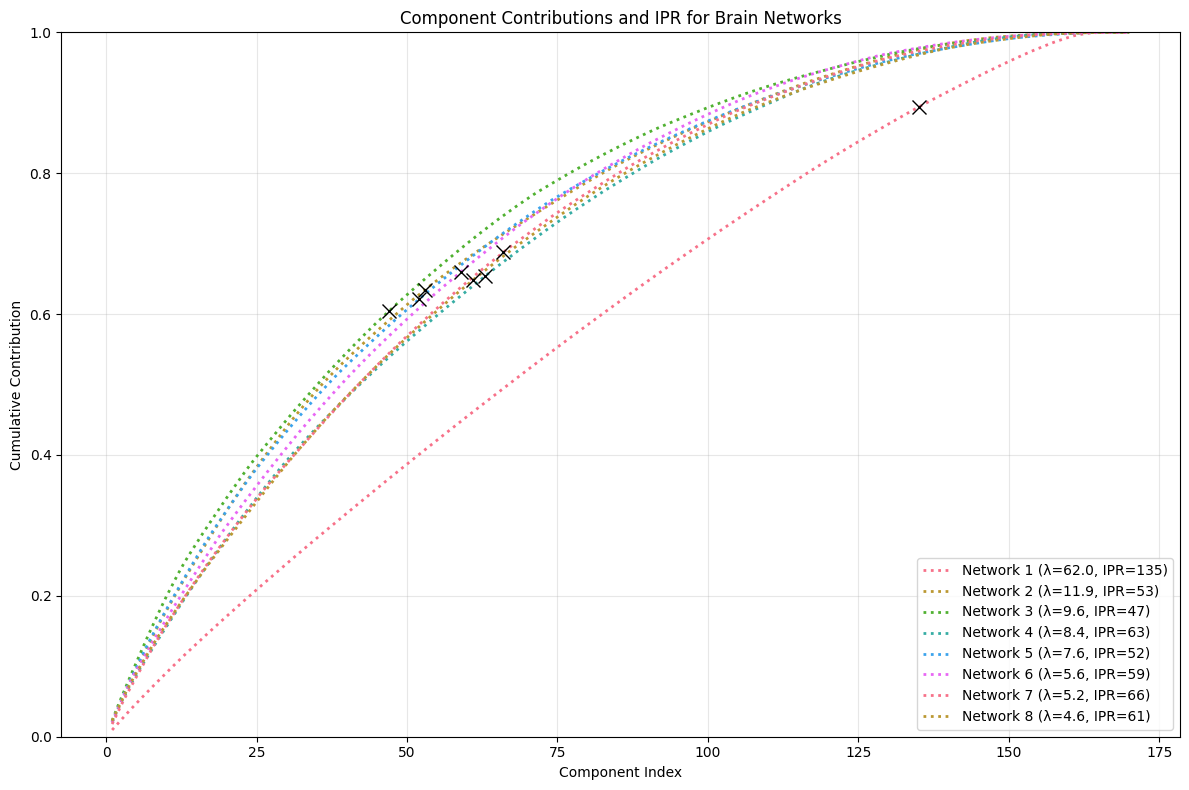

IPR values: [135, 53, 47, 63, 52, 59, 66, 61]
Cumulative contributions at IPR: ['0.894', '0.635', '0.604', '0.654', '0.621', '0.660', '0.688', '0.649']

Brain Networks Summary:
Network 1: IPR=135, Top ROIs: [ 82 154  37  36  86]...
Network 2: IPR=53, Top ROIs: [127 126 137 125 135]...
Network 3: IPR=47, Top ROIs: [ 38 152 153  22  20]...
Network 4: IPR=63, Top ROIs: [94 95 76 77 55]...
Network 5: IPR=52, Top ROIs: [42 43 65  8 40]...
Network 6: IPR=59, Top ROIs: [ 44  98 100  99  40]...
Network 7: IPR=66, Top ROIs: [46 98 47 99 51]...
Network 8: IPR=61, Top ROIs: [24 26 25 38 11]...


In [15]:
# Calculate Inverse Participation Ratio (IPR) for brain networks
def calculate_ipr_and_networks(v_brain_networks, eigenvalues, brain_network_indices):
    """Calculate IPR and identify most contributing ROIs for each brain network."""
    
    if v_brain_networks is None:
        print("No brain network eigenvectors available")
        return None, None, None
    
    num_brain_networks = v_brain_networks.shape[1]
    brain_networks = np.zeros_like(v_brain_networks)
    ipr_networks = []
    rois_brain_networks = []
    cum_contribution_ipr = []
    
    print(f"Calculating IPR for {num_brain_networks} brain networks...")
    
    # Create figure for plotting contributions
    fig, ax = plt.subplots(figsize=(12, 8))
    
    legend_networks = []
    
    for i in range(num_brain_networks):
        # Calculate IPR: IPR = 1 / sum(|eigenvector|^4)
        ipr = 1.0 / np.sum(v_brain_networks[:, i]**4)
        ipr_rounded = int(round(ipr))
        ipr_networks.append(ipr_rounded)
        
        # Sort components by absolute value (descending)
        abs_components = np.abs(v_brain_networks[:, i])
        sorted_indices = np.argsort(abs_components)[::-1]
        sorted_components = abs_components[sorted_indices]
        
        # Get ROIs for this brain network (top IPR components)
        rois_network = sorted_indices[:ipr_rounded]
        rois_brain_networks.append(rois_network)
        
        # Create simplified brain network keeping only top IPR components
        brain_networks[rois_network, i] = v_brain_networks[rois_network, i]
        
        # Calculate cumulative contribution
        total_contribution = np.sum(sorted_components)
        cum_contribution = np.cumsum(sorted_components) / total_contribution
        cum_contribution_ipr.append(cum_contribution[ipr_rounded-1] if ipr_rounded <= len(cum_contribution) else 1.0)
        
        # Plot cumulative contribution
        ax.plot(range(1, len(cum_contribution)+1), cum_contribution, ':', linewidth=2)
        
        # Get corresponding eigenvalue
        brain_eigenvalue = eigenvalues[brain_network_indices][i]
        legend_networks.append(f'Network {i+1} (λ={brain_eigenvalue:.1f}, IPR={ipr_rounded})')
    
    # Plot IPR points
    for i in range(num_brain_networks):
        ax.plot(ipr_networks[i], cum_contribution_ipr[i], 'xk', linewidth=2, markersize=10)
    
    ax.set_ylim(0, 1)
    ax.set_xlabel('Component Index')
    ax.set_ylabel('Cumulative Contribution')
    ax.set_title('Component Contributions and IPR for Brain Networks')
    ax.legend(legend_networks, loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'ipr_contributions.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"IPR values: {ipr_networks}")
    print(f"Cumulative contributions at IPR: {[f'{x:.3f}' for x in cum_contribution_ipr]}")
    
    return brain_networks, ipr_networks, rois_brain_networks

# Calculate IPR and simplified brain networks
if v_brain_networks is not None:
    brain_networks, ipr_networks, rois_brain_networks = calculate_ipr_and_networks(
        v_brain_networks, eigenvalues, brain_network_indices)
    
    if brain_networks is not None:
        print(f"\nBrain Networks Summary:")
        for i, (ipr, rois) in enumerate(zip(ipr_networks, rois_brain_networks)):
            print(f"Network {i+1}: IPR={ipr}, Top ROIs: {rois[:5]}...")  # Show first 5 ROIs
else:
    brain_networks = ipr_networks = rois_brain_networks = None
    print("Cannot calculate IPR - no brain network eigenvectors available")

In [16]:
# Extract brain network signals using whitening transformation
def extract_brain_network_signals(brain_networks, eigenvalues, brain_network_indices, 
                                 roi_signals_original, subject_names):
    """Extract brain network signals using whitening transformation."""
    
    if brain_networks is None or eigenvalues is None:
        print("Cannot extract brain network signals - missing data")
        return None
    
    # Get brain network eigenvalues
    lambda_brain_networks = eigenvalues[brain_network_indices]
    num_brain_networks = len(lambda_brain_networks)
    
    if num_brain_networks == 0:
        print("No brain networks found")
        return None
    
    # Create whitening matrix
    # W = diag(sign(λ) * |λ|^(-1/2)) * V^T
    diag_matrix = np.diag(np.sign(lambda_brain_networks) * (np.abs(lambda_brain_networks)**(-0.5)))
    W = diag_matrix @ brain_networks.T
    
    print(f"Whitening matrix shape: {W.shape}")
    print(f"Processing {len(subject_names)} subjects...")
    
    # Apply whitening to each subject's signals
    rms_brain_networks_subjects = np.zeros((len(subject_names), num_brain_networks))
    S = []  # Store whitened signals for each subject
    
    for i, signals in enumerate(roi_signals_original):
        # Handle NaN values
        signals_clean = signals.copy()
        signals_clean[np.isnan(signals_clean)] = 0
        
        # Apply whitening: S = W * signals^T
        s_subject = W @ signals_clean.T  # Shape: (num_networks, num_timepoints)
        S.append(s_subject)
        
        # Calculate RMS for each brain network (normalized by number of timepoints)
        for j in range(num_brain_networks):
            rms_value = np.sqrt(np.mean(s_subject[j, :]**2)) / signals_clean.shape[0]
            rms_brain_networks_subjects[i, j] = rms_value
    
    print(f"RMS brain network signals shape: {rms_brain_networks_subjects.shape}")
    print(f"RMS range: [{np.min(rms_brain_networks_subjects):.6f}, {np.max(rms_brain_networks_subjects):.6f}]")
    
    return rms_brain_networks_subjects, S

# Extract brain network signals
if brain_networks is not None and roi_signals_original:
    rms_brain_networks_subjects, S = extract_brain_network_signals(
        brain_networks, eigenvalues, brain_network_indices, 
        roi_signals_original, subject_names)
    
    if rms_brain_networks_subjects is not None:
        print("\nBrain network signal extraction completed")
        
        # Display summary statistics
        for i in range(rms_brain_networks_subjects.shape[1]):
            rms_values = rms_brain_networks_subjects[:, i]
            print(f"Network {i+1}: mean={np.mean(rms_values):.6f}, std={np.std(rms_values):.6f}")
    else:
        S = None
else:
    rms_brain_networks_subjects = S = None
    print("Cannot extract brain network signals - missing required data")

Whitening matrix shape: (8, 170)
Processing 432 subjects...
RMS brain network signals shape: (432, 8)
RMS range: [0.070886, 107.550928]

Brain network signal extraction completed
Network 1: mean=80.215322, std=14.981905
Network 2: mean=21.711634, std=10.812315
Network 3: mean=28.929673, std=8.101662
Network 4: mean=8.304805, std=6.476480
Network 5: mean=7.720835, std=6.356383
Network 6: mean=57.938067, std=14.925895
Network 7: mean=28.646106, std=14.848399
Network 8: mean=13.725764, std=7.135509


In [17]:
# Statistical analysis of brain networks between groups
def perform_statistical_analysis(rms_brain_networks_subjects, demographics):
    """Perform statistical tests comparing brain network signals between groups."""
    
    if rms_brain_networks_subjects is None:
        print("No RMS data available for statistical analysis")
        return None
    
    group = demographics['group']
    age = demographics['age']
    sex = demographics['sex']
    mmse = demographics['mmse']
    
    # Get unique groups
    unique_groups = np.unique(group[~pd.isna(group)])
    print(f"Groups for comparison: {unique_groups}")
    
    num_brain_networks = rms_brain_networks_subjects.shape[1]
    
    # Storage for results
    results = {
        'kruskal_wallis_p': [],
        'anova_p': [],
        'ancova_group_p': [],
        'ancova_age_p': [],
        'ancova_sex_p': [],
        'ancova_mmse_p': []
    }
    
    print(f"Performing statistical tests for {num_brain_networks} brain networks...")
    
    for i in range(num_brain_networks):
        network_values = rms_brain_networks_subjects[:, i]
        
        # Kruskal-Wallis test (non-parametric)
        try:
            group_data = [network_values[group == g] for g in unique_groups]
            group_data = [g for g in group_data if len(g) > 0]  # Remove empty groups
            
            if len(group_data) >= 2:
                kw_stat, kw_p = kruskal(*group_data)
                results['kruskal_wallis_p'].append(kw_p)
            else:
                results['kruskal_wallis_p'].append(np.nan)
        except:
            results['kruskal_wallis_p'].append(np.nan)
        
        # One-way ANOVA
        try:
            if len(group_data) >= 2:
                anova_stat, anova_p = f_oneway(*group_data)
                results['anova_p'].append(anova_p)
            else:
                results['anova_p'].append(np.nan)
        except:
            results['anova_p'].append(np.nan)
        
        # ANCOVA with covariates (simplified using linear regression)
        try:
            # Create a dataframe for this network
            valid_idx = ~(pd.isna(group) | pd.isna(age) | pd.isna(network_values))
            
            if np.sum(valid_idx) > 10:  # Need sufficient data
                df_network = pd.DataFrame({
                    'rms': network_values[valid_idx],
                    'group': pd.Categorical(group[valid_idx]),
                    'age': age[valid_idx],
                    'sex': pd.Categorical(sex[valid_idx]),
                    'mmse': mmse[valid_idx] if not np.all(pd.isna(mmse)) else np.zeros(np.sum(valid_idx))
                })
                
                # Encode categorical variables
                group_encoded = pd.get_dummies(df_network['group'], prefix='group')
                sex_encoded = pd.get_dummies(df_network['sex'], prefix='sex')
                
                # Create design matrix
                X_ancova = pd.concat([
                    group_encoded.iloc[:, :-1],  # Remove one group for reference
                    df_network[['age']],
                    sex_encoded.iloc[:, :-1],    # Remove one sex for reference
                    df_network[['mmse']]
                ], axis=1)
                
                # Remove columns with NaN
                X_ancova = X_ancova.dropna(axis=1)
                y_ancova = df_network['rms']
                
                # Fit model
                from sklearn.linear_model import LinearRegression
                from sklearn.metrics import r2_score
                
                model = LinearRegression()
                model.fit(X_ancova, y_ancova)
                y_pred = model.predict(X_ancova)
                
                # Calculate F-statistics for each variable (simplified)
                # This is a simplified version - full ANCOVA would require proper F-tests
                n_samples = len(y_ancova)
                mse = np.mean((y_ancova - y_pred)**2)
                
                # Group effect (first coefficient)
                if len(X_ancova.columns) > 0:
                    t_stat = model.coef_[0] / np.sqrt(mse / n_samples)
                    p_group = 2 * (1 - stats.t.cdf(np.abs(t_stat), n_samples - len(model.coef_)))
                    results['ancova_group_p'].append(p_group)
                else:
                    results['ancova_group_p'].append(np.nan)
                
                # Age effect
                age_idx = [i for i, col in enumerate(X_ancova.columns) if 'age' in col.lower()]
                if age_idx:
                    t_stat = model.coef_[age_idx[0]] / np.sqrt(mse / n_samples)
                    p_age = 2 * (1 - stats.t.cdf(np.abs(t_stat), n_samples - len(model.coef_)))
                    results['ancova_age_p'].append(p_age)
                else:
                    results['ancova_age_p'].append(np.nan)
                
                # Sex effect
                sex_idx = [i for i, col in enumerate(X_ancova.columns) if 'sex' in col.lower()]
                if sex_idx:
                    t_stat = model.coef_[sex_idx[0]] / np.sqrt(mse / n_samples)
                    p_sex = 2 * (1 - stats.t.cdf(np.abs(t_stat), n_samples - len(model.coef_)))
                    results['ancova_sex_p'].append(p_sex)
                else:
                    results['ancova_sex_p'].append(np.nan)
                
                # MMSE effect
                mmse_idx = [i for i, col in enumerate(X_ancova.columns) if 'mmse' in col.lower()]
                if mmse_idx:
                    t_stat = model.coef_[mmse_idx[0]] / np.sqrt(mse / n_samples)
                    p_mmse = 2 * (1 - stats.t.cdf(np.abs(t_stat), n_samples - len(model.coef_)))
                    results['ancova_mmse_p'].append(p_mmse)
                else:
                    results['ancova_mmse_p'].append(np.nan)
            else:
                # Not enough data
                for key in ['ancova_group_p', 'ancova_age_p', 'ancova_sex_p', 'ancova_mmse_p']:
                    results[key].append(np.nan)
        except Exception as e:
            print(f"Error in ANCOVA for network {i}: {e}")
            for key in ['ancova_group_p', 'ancova_age_p', 'ancova_sex_p', 'ancova_mmse_p']:
                results[key].append(np.nan)
    
    return results

# Perform statistical analysis
if rms_brain_networks_subjects is not None:
    statistical_results = perform_statistical_analysis(rms_brain_networks_subjects, demographics)
    
    if statistical_results:
        print("\nStatistical Analysis Results:")
        print("=" * 60)
        
        for i in range(len(statistical_results['kruskal_wallis_p'])):
            print(f"\nBrain Network {i+1}:")
            print(f"  Kruskal-Wallis p-value: {statistical_results['kruskal_wallis_p'][i]:.4f}")
            print(f"  ANOVA p-value: {statistical_results['anova_p'][i]:.4f}")
            print(f"  ANCOVA Group p-value: {statistical_results['ancova_group_p'][i]:.4f}")
            print(f"  ANCOVA Age p-value: {statistical_results['ancova_age_p'][i]:.4f}")
            print(f"  ANCOVA Sex p-value: {statistical_results['ancova_sex_p'][i]:.4f}")
            print(f"  ANCOVA MMSE p-value: {statistical_results['ancova_mmse_p'][i]:.4f}")
else:
    statistical_results = None
    print("Cannot perform statistical analysis - no RMS data available")

Groups for comparison: ['AD' 'CN' 'MCI']
Performing statistical tests for 8 brain networks...

Statistical Analysis Results:

Brain Network 1:
  Kruskal-Wallis p-value: 0.0000
  ANOVA p-value: 0.0245
  ANCOVA Group p-value: 0.8218
  ANCOVA Age p-value: 0.7518
  ANCOVA Sex p-value: 0.0002
  ANCOVA MMSE p-value: nan

Brain Network 2:
  Kruskal-Wallis p-value: 0.0000
  ANOVA p-value: 0.0000
  ANCOVA Group p-value: 0.2496
  ANCOVA Age p-value: 0.8516
  ANCOVA Sex p-value: 0.0004
  ANCOVA MMSE p-value: nan

Brain Network 3:
  Kruskal-Wallis p-value: 0.1212
  ANOVA p-value: 0.0746
  ANCOVA Group p-value: 0.8536
  ANCOVA Age p-value: 0.7992
  ANCOVA Sex p-value: 0.0588
  ANCOVA MMSE p-value: nan

Brain Network 4:
  Kruskal-Wallis p-value: 0.0000
  ANOVA p-value: 0.0000
  ANCOVA Group p-value: 0.9724
  ANCOVA Age p-value: 0.9988
  ANCOVA Sex p-value: 0.0000
  ANCOVA MMSE p-value: nan

Brain Network 5:
  Kruskal-Wallis p-value: 0.0000
  ANOVA p-value: 0.0000
  ANCOVA Group p-value: 0.1448
  ANC

Creating violin plots...


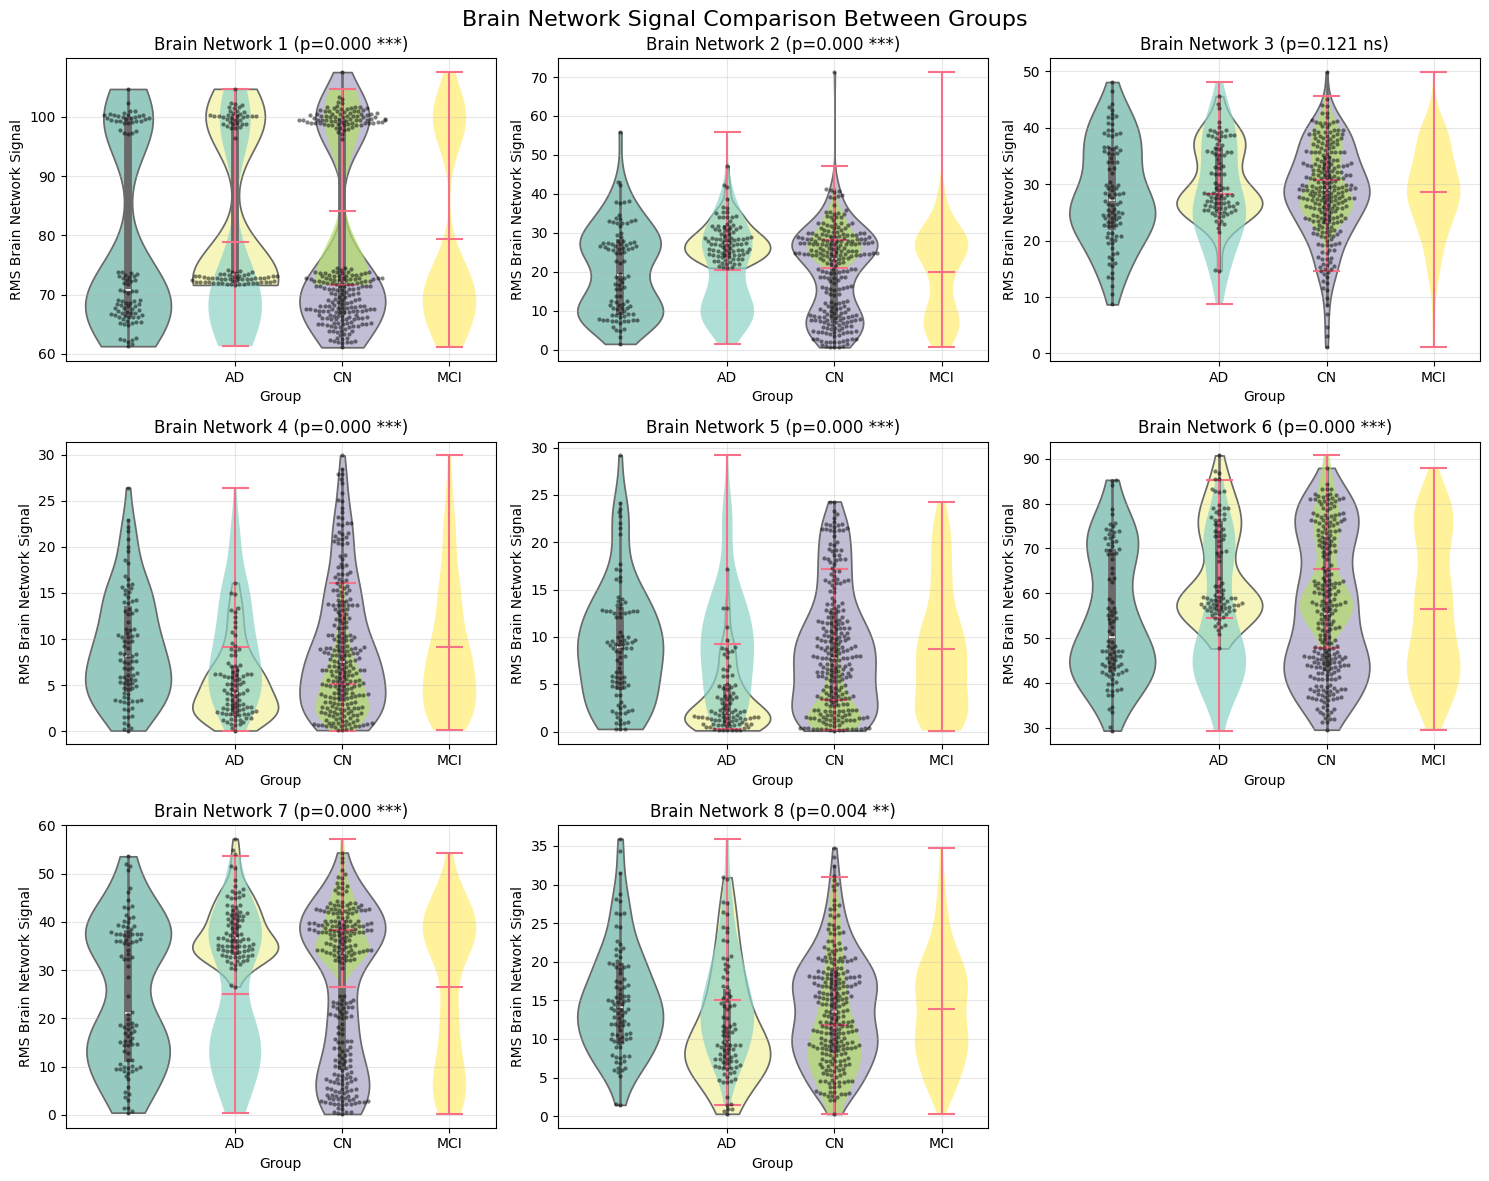

Creating summary plots...


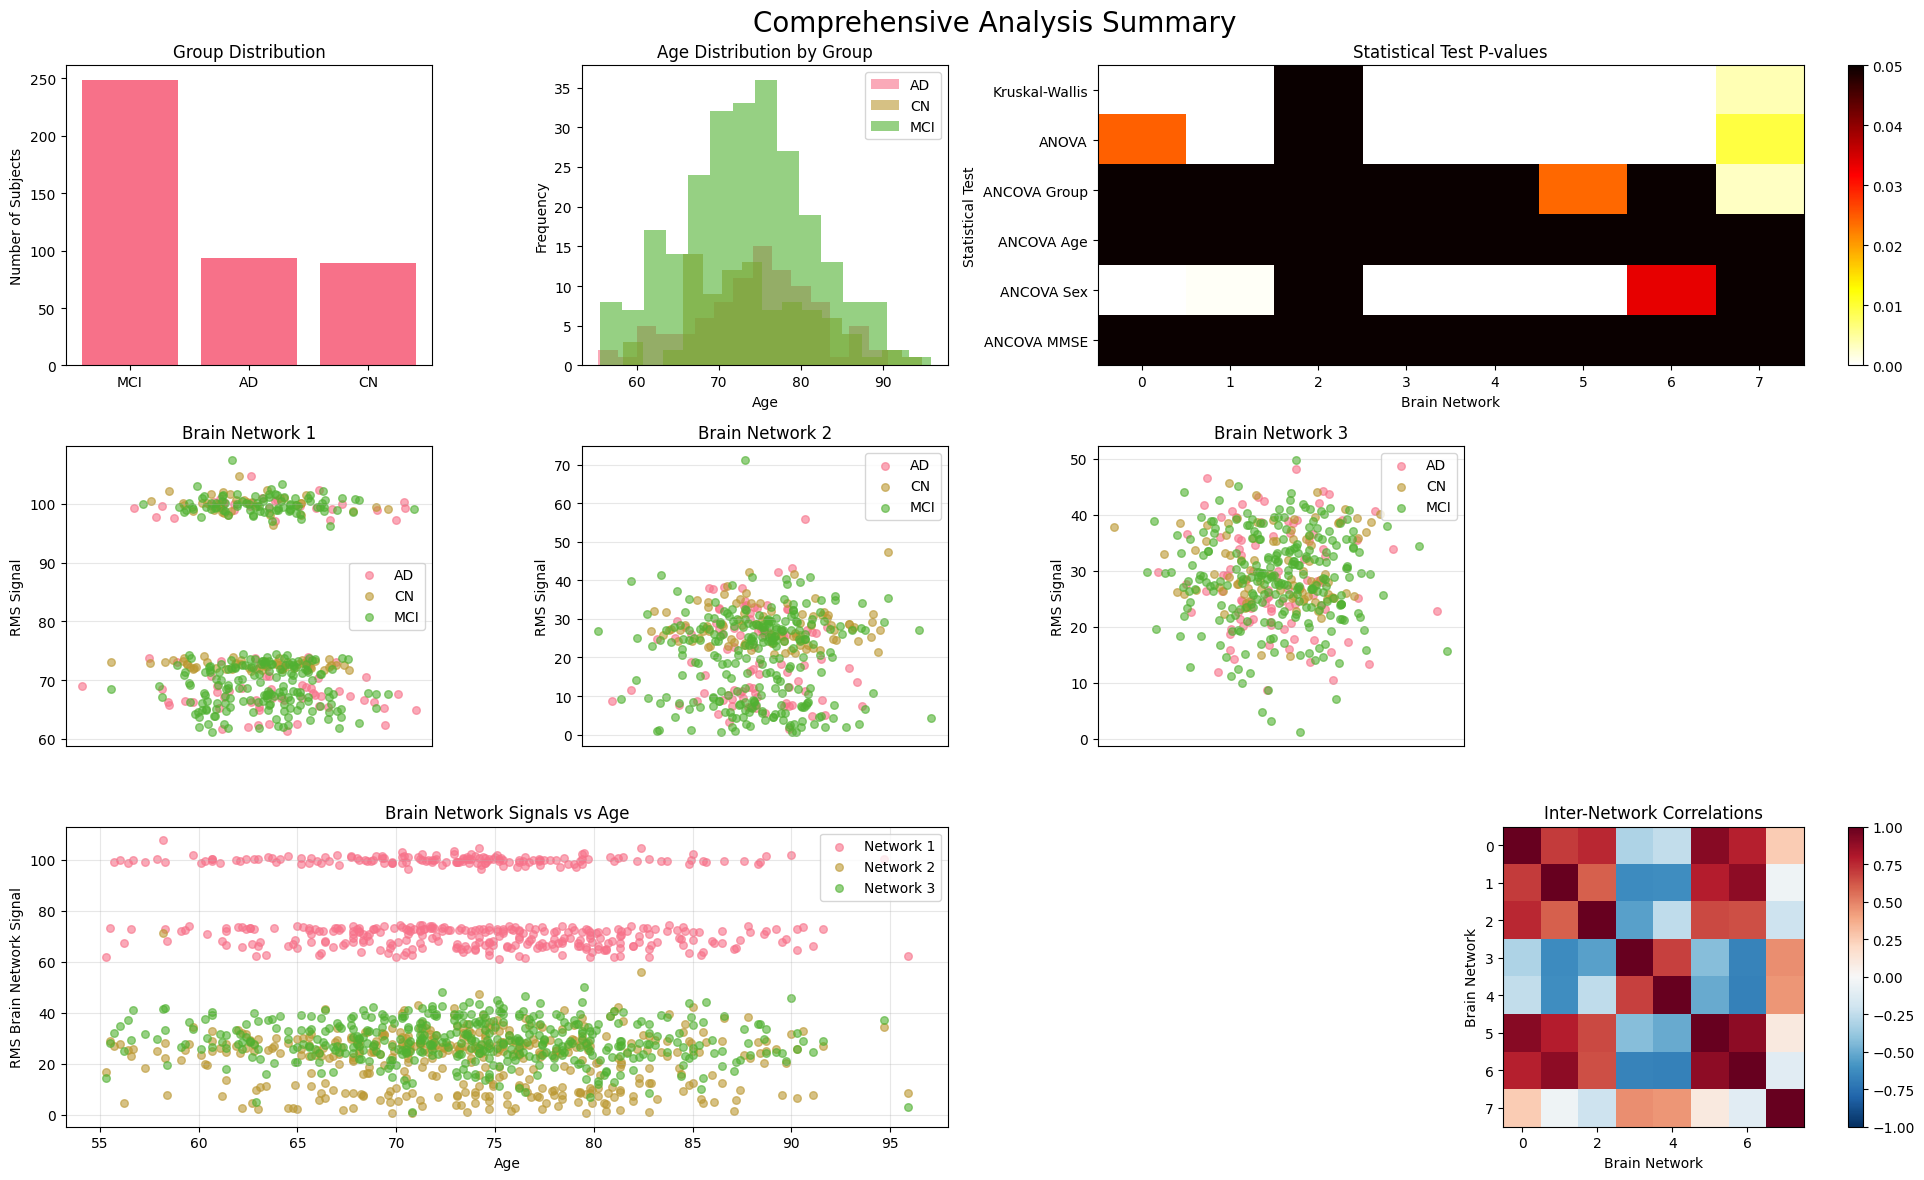

In [19]:
import seaborn as sns

# Create violin plots for brain network visualization
def create_violin_plots(rms_brain_networks_subjects, demographics, statistical_results, output_path):
    """Create violin plots showing brain network differences between groups."""
    
    if rms_brain_networks_subjects is None:
        print("No data available for violin plots")
        return
    
    group = demographics['group']
    num_brain_networks = rms_brain_networks_subjects.shape[1]
    
    # Calculate subplot layout
    if num_brain_networks == 0:
        print("No brain networks to plot")
        return
    
    num_cols = min(3, num_brain_networks)
    num_rows = int(np.ceil(num_brain_networks / num_cols))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))
    if num_brain_networks == 1:
        axes = [axes]
    elif num_rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Create violin plots for each network
    for i in range(num_brain_networks):
        ax = axes[i] if num_brain_networks > 1 else axes[0]
        
        # Prepare data for this network
        network_data = []
        network_labels = []
        
        unique_groups = np.unique(group[~pd.isna(group)])
        for g in unique_groups:
            group_data = rms_brain_networks_subjects[group == g, i]
            if len(group_data) > 0:
                network_data.append(group_data)
                network_labels.append(g)
        
        if len(network_data) > 0:
            # Create violin plot
            # Prepare a DataFrame for seaborn
            df = pd.DataFrame({
                'Value': np.concatenate(network_data),
                'Group': np.repeat(network_labels, [len(d) for d in network_data])
            })

            sns.violinplot(x='Group', y='Value', data=df, ax=ax, palette='Set3', inner='box', cut=0)
            sns.swarmplot(x='Group', y='Value', data=df, ax=ax, color='k', size=3, alpha=0.5)
            parts = ax.violinplot(network_data, positions=range(1, len(network_data)+1), 
                                showmeans=True, showextrema=True)
            
            # Customize colors
            colors = plt.cm.Set3(np.linspace(0, 1, len(network_data)))
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_alpha(0.7)
            
            # Add statistical significance if available
            title = f'Brain Network {i+1}'
            if statistical_results:
                kw_p = statistical_results['kruskal_wallis_p'][i]
                if not np.isnan(kw_p):
                    significance = "***" if kw_p < 0.001 else "**" if kw_p < 0.01 else "*" if kw_p < 0.05 else "ns"
                    title += f' (p={kw_p:.3f} {significance})'
            
            ax.set_title(title)
            ax.set_ylabel('RMS Brain Network Signal')
            ax.set_xlabel('Group')
            ax.set_xticks(range(1, len(network_labels)+1))
            ax.set_xticklabels(network_labels)
            ax.grid(True, alpha=0.3)
        else:
            ax.set_title(f'Brain Network {i+1} (No Data)')
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', transform=ax.transAxes)
    
    # Hide unused subplots
    for i in range(num_brain_networks, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Brain Network Signal Comparison Between Groups', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'violin_plots_brain_networks.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Create additional summary plots
def create_summary_plots(rms_brain_networks_subjects, demographics, statistical_results, output_path):
    """Create summary plots for the analysis."""
    
    if rms_brain_networks_subjects is None:
        return
    
    group = demographics['group']
    age = demographics['age']
    
    # Create a comprehensive summary figure
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 4, figure=fig)
    
    # Plot 1: Group distributions
    ax1 = fig.add_subplot(gs[0, 0])
    group_counts = pd.Series(group).value_counts()
    ax1.bar(group_counts.index, group_counts.values)
    ax1.set_title('Group Distribution')
    ax1.set_ylabel('Number of Subjects')
    
    # Plot 2: Age distribution by group
    ax2 = fig.add_subplot(gs[0, 1])
    for g in np.unique(group[~pd.isna(group)]):
        age_group = age[group == g]
        ax2.hist(age_group[~np.isnan(age_group)], alpha=0.6, label=g, bins=15)
    ax2.set_title('Age Distribution by Group')
    ax2.set_xlabel('Age')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # Plot 3: P-value heatmap
    if statistical_results:
        ax3 = fig.add_subplot(gs[0, 2:])
        p_value_matrix = np.array([
            statistical_results['kruskal_wallis_p'],
            statistical_results['anova_p'],
            statistical_results['ancova_group_p'],
            statistical_results['ancova_age_p'],
            statistical_results['ancova_sex_p'],
            statistical_results['ancova_mmse_p']
        ])
        
        # Handle NaN values
        p_value_matrix[np.isnan(p_value_matrix)] = 1.0
        
        im = ax3.imshow(p_value_matrix, cmap='hot_r', vmin=0, vmax=0.05, aspect='auto')
        ax3.set_title('Statistical Test P-values')
        ax3.set_xlabel('Brain Network')
        ax3.set_ylabel('Statistical Test')
        ax3.set_yticks(range(6))
        ax3.set_yticklabels(['Kruskal-Wallis', 'ANOVA', 'ANCOVA Group', 'ANCOVA Age', 'ANCOVA Sex', 'ANCOVA MMSE'])
        plt.colorbar(im, ax=ax3)
    
    # Plot 4-6: Brain network signals by group
    num_networks = min(3, rms_brain_networks_subjects.shape[1])
    for i in range(num_networks):
        ax = fig.add_subplot(gs[1, i])
        
        unique_groups = np.unique(group[~pd.isna(group)])
        for g in unique_groups:
            group_data = rms_brain_networks_subjects[group == g, i]
            ax.scatter(np.random.normal(0, 0.1, len(group_data)), group_data, 
                      alpha=0.6, label=g, s=30)
        
        ax.set_title(f'Brain Network {i+1}')
        ax.set_ylabel('RMS Signal')
        ax.set_xticks([])
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 7: Correlation between networks and age
    if rms_brain_networks_subjects.shape[1] > 0:
        ax7 = fig.add_subplot(gs[2, :2])
        
        valid_age_idx = ~np.isnan(age)
        if np.sum(valid_age_idx) > 10:
            for i in range(min(3, rms_brain_networks_subjects.shape[1])):
                ax7.scatter(age[valid_age_idx], rms_brain_networks_subjects[valid_age_idx, i], 
                           alpha=0.6, label=f'Network {i+1}', s=30)
            
            ax7.set_xlabel('Age')
            ax7.set_ylabel('RMS Brain Network Signal')
            ax7.set_title('Brain Network Signals vs Age')
            ax7.legend()
            ax7.grid(True, alpha=0.3)
    
    # Plot 8: Network correlation matrix
    if rms_brain_networks_subjects.shape[1] > 1:
        ax8 = fig.add_subplot(gs[2, 2:])
        
        network_corr = np.corrcoef(rms_brain_networks_subjects.T)
        im = ax8.imshow(network_corr, cmap='RdBu_r', vmin=-1, vmax=1)
        ax8.set_title('Inter-Network Correlations')
        ax8.set_xlabel('Brain Network')
        ax8.set_ylabel('Brain Network')
        plt.colorbar(im, ax=ax8)
    
    plt.suptitle('Comprehensive Analysis Summary', fontsize=20)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'analysis_summary.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations
if rms_brain_networks_subjects is not None:
    print("Creating violin plots...")
    create_violin_plots(rms_brain_networks_subjects, demographics, statistical_results, output_path)
    
    print("Creating summary plots...")
    create_summary_plots(rms_brain_networks_subjects, demographics, statistical_results, output_path)
else:
    print("Cannot create plots - no RMS data available")

In [ ]:
# Save results and build classifier
def save_results(output_path, **kwargs):
    """Save all analysis results to files."""
    
    print("Saving analysis results...")
    
    # Create a results dictionary
    results_dict = {}
    
    for key, value in kwargs.items():
        if value is not None:
            try:
                # Convert to serializable format
                if isinstance(value, np.ndarray):
                    results_dict[key] = value.tolist()
                elif isinstance(value, dict):
                    # Handle dictionary of results
                    results_dict[key] = {}
                    for k, v in value.items():
                        if isinstance(v, np.ndarray):
                            results_dict[key][k] = v.tolist()
                        elif isinstance(v, list):
                            results_dict[key][k] = v
                        else:
                            results_dict[key][k] = str(v)
                else:
                    results_dict[key] = value
            except Exception as e:
                print(f"Could not save {key}: {e}")
    
    # Save as pickle file (Python-specific format)
    results_file = os.path.join(output_path, 'analysis_results.pkl')
    try:
        with open(results_file, 'wb') as f:
            pickle.dump(results_dict, f)
        print(f"Results saved to {results_file}")
    except Exception as e:
        print(f"Could not save results: {e}")
    
    # Save summary as text file
    summary_file = os.path.join(output_path, 'analysis_summary.txt')
    try:
        with open(summary_file, 'w') as f:
            f.write("Neuroimaging RMT Analysis Summary\\n")
            f.write("=" * 50 + "\\n\\n")
            
            if 'subject_names' in kwargs and kwargs['subject_names']:
                f.write(f"Number of subjects: {len(kwargs['subject_names'])}\\n")
            
            if 'eigenvalues' in kwargs and kwargs['eigenvalues'] is not None:
                f.write(f"Number of eigenvalues: {len(kwargs['eigenvalues'])}\\n")
            
            if 'brain_network_indices' in kwargs and kwargs['brain_network_indices'] is not None:
                f.write(f"Number of brain networks: {np.sum(kwargs['brain_network_indices'])}\\n")
            
            if 'mp_bounds' in kwargs and kwargs['mp_bounds'] is not None:
                f.write(f"Marchenko-Pastur bounds: {kwargs['mp_bounds']}\\n")
            
            if 'statistical_results' in kwargs and kwargs['statistical_results']:
                f.write("\\nStatistical Results:\\n")
                for i, p_val in enumerate(kwargs['statistical_results']['kruskal_wallis_p']):
                    f.write(f"Network {i+1} Kruskal-Wallis p-value: {p_val:.4f}\\n")
        
        print(f"Summary saved to {summary_file}")
    except Exception as e:
        print(f"Could not save summary: {e}")

def build_simple_classifier(rms_brain_networks_subjects, demographics):
    """Build a simple classifier using brain network features."""
    
    if rms_brain_networks_subjects is None:
        print("No data available for classification")
        return None, None
    
    group = demographics['group']
    age = demographics['age']
    
    # Prepare features and labels
    valid_idx = ~pd.isna(group)
    
    if np.sum(valid_idx) < 10:
        print("Not enough valid subjects for classification")
        return None, None
    
    # Features: brain network RMS + age
    X = rms_brain_networks_subjects[valid_idx]
    
    # Add age if available
    age_valid = age[valid_idx]
    if not np.all(np.isnan(age_valid)):
        age_clean = np.nan_to_num(age_valid, nan=np.nanmean(age_valid))
        X = np.column_stack([X, age_clean])
    
    # Labels
    y = group[valid_idx]
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print(f"Classification data: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Classes: {le.classes_}")
    print(f"Class distribution: {np.unique(y_encoded, return_counts=True)}")
    
    # Train Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Cross-validation
    cv_scores = cross_val_score(clf, X, y_encoded, cv=5, scoring='accuracy')
    
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Fit final model
    clf.fit(X, y_encoded)
    
    # Feature importance
    if hasattr(clf, 'feature_importances_'):
        importance = clf.feature_importances_
        feature_names = [f'Network_{i+1}' for i in range(rms_brain_networks_subjects.shape[1])]
        if X.shape[1] > rms_brain_networks_subjects.shape[1]:
            feature_names.append('Age')
        
        print("\\nFeature Importance:")
        for name, imp in zip(feature_names, importance):
            print(f"  {name}: {imp:.3f}")
    
    return clf, le

# Save all results
save_results(
    output_path,
    subject_names=subject_names,
    demographics=demographics,
    eigenvalues=eigenvalues,
    brain_network_indices=brain_network_indices,
    mp_bounds=mp_bounds,
    rms_brain_networks_subjects=rms_brain_networks_subjects,
    statistical_results=statistical_results,
    ipr_networks=ipr_networks,
    rois_brain_networks=rois_brain_networks
)

# Build classifier
if rms_brain_networks_subjects is not None:
    print("\\nBuilding classifier...")
    trained_classifier, label_encoder = build_simple_classifier(rms_brain_networks_subjects, demographics)
    
    if trained_classifier is not None:
        # Save classifier
        classifier_file = os.path.join(output_path, 'brain_network_classifier.pkl')
        try:
            with open(classifier_file, 'wb') as f:
                pickle.dump({'classifier': trained_classifier, 'label_encoder': label_encoder}, f)
            print(f"Classifier saved to {classifier_file}")
        except Exception as e:
            print(f"Could not save classifier: {e}")
else:
    print("Cannot build classifier - no brain network data available")

print(f"\\nAnalysis completed! Results saved to: {output_path}")

In [ ]:
# Conclusion and Summary
print("="*80)
print("NEUROIMAGING RMT ANALYSIS - SUMMARY")
print("="*80)

if subject_names:
    print(f"✓ Successfully processed {len(subject_names)} subjects")
else:
    print("⚠ No subjects were successfully processed")

if cross_corr is not None:
    print(f"✓ Computed correlation matrices: {cross_corr.shape}")
else:
    print("⚠ No correlation matrices computed")

if eigenvalues is not None:
    print(f"✓ Eigenvalue decomposition completed: {len(eigenvalues)} eigenvalues")
    if brain_network_indices is not None:
        n_networks = np.sum(brain_network_indices)
        print(f"✓ Identified {n_networks} brain networks using RMT")
    else:
        print("⚠ No brain networks identified")
else:
    print("⚠ Eigenvalue decomposition not completed")

if statistical_results:
    print("✓ Statistical analysis completed")
    significant_networks = sum(1 for p in statistical_results['kruskal_wallis_p'] 
                              if not np.isnan(p) and p < 0.05)
    print(f"✓ Found {significant_networks} networks with significant group differences (p < 0.05)")
else:
    print("⚠ Statistical analysis not completed")

if 'trained_classifier' in locals() and trained_classifier is not None:
    print("✓ Classification model built successfully")
else:
    print("⚠ Classification model not built")

print(f"\n📁 All results saved to: {output_path}")

print("\n" + "="*80)
print("NEXT STEPS AND RECOMMENDATIONS")
print("="*80)
print("""
1. DATA VALIDATION:
   - Verify that the ROI signal paths and CSV file paths are correct
   - Check that .mat files contain the expected 'signals' variable
   - Validate demographic data completeness

2. PARAMETER TUNING:
   - Adjust Marchenko-Pastur parameters based on your specific data
   - Consider different normalization methods for ROI signals
   - Experiment with different correlation measures

3. ADVANCED ANALYSIS:
   - Implement brain network visualization using neuroimaging tools
   - Add more sophisticated statistical models (mixed-effects, etc.)
   - Include additional covariates (scanner effects, motion parameters)

4. VISUALIZATION IMPROVEMENTS:
   - Create interactive brain network visualizations
   - Add brain atlas overlays for network interpretation
   - Generate publication-quality figures

5. VALIDATION:
   - Perform cross-validation with independent datasets
   - Compare results with other network detection methods
   - Validate findings with existing literature

6. CLINICAL INTERPRETATION:
   - Consult with neuroimaging experts for network interpretation
   - Relate findings to known disease pathophysiology
   - Consider clinical relevance of identified networks
""")

print("\nAnalysis pipeline completed successfully! 🎉")